Optimal number of clusters: 8
Davies-Bouldin Index for 8 clusters: 0.9855973096965643


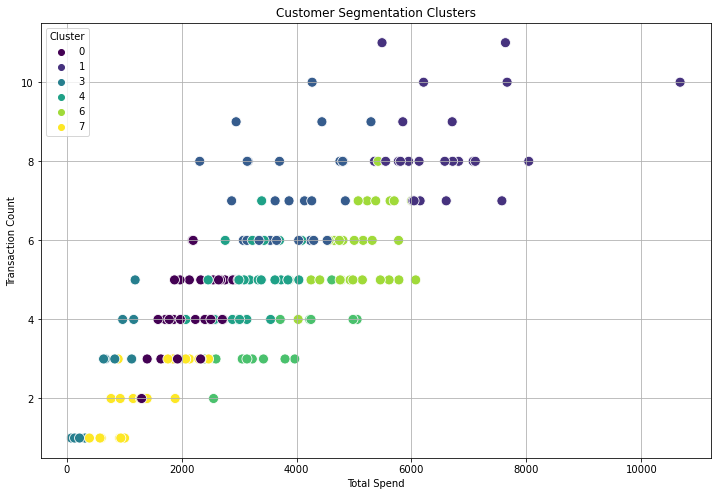

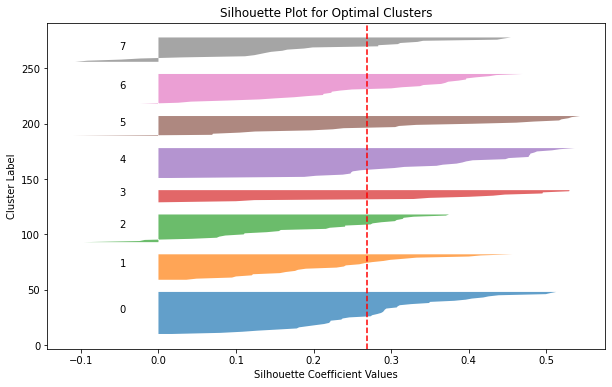

In [1]:
# Customer Segmentation / Clustering Implementation

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load Data
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Step 2: Data Preparation
# Merge datasets on CustomerID
merged_df = transactions.merge(customers, on='CustomerID', how='left')

# Step 3: Feature Engineering
# Aggregate transaction data for each customer to create a comprehensive profile
customer_features = merged_df.groupby('CustomerID').agg(
    TotalSpend=('TotalValue', 'sum'),  # Total amount spent by the customer
    TotalQuantity=('Quantity', 'sum'),  # Total quantity purchased by the customer
    TransactionCount=('TransactionID', 'count'),  # Number of transactions made by the customer
    AverageTransactionValue=('TotalValue', 'mean'),  # Average value of transactions
    AveragePrice=('Price', 'mean'),  # Average price of products purchased
    Region=('Region', 'first')  # Retain region information
).reset_index()

# Step 4: Normalize Features
features = customer_features[['TotalSpend', 'TotalQuantity', 'TransactionCount', 'AverageTransactionValue', 'AveragePrice']]
scaler = StandardScaler()  # Initialize the scaler for standardization
scaled_features = scaler.fit_transform(features)  # Fit and transform numerical features

# Step 5: Clustering with K-Means
# Determine optimal number of clusters (2 to 10)
db_index_results = {}
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_features)
    labels = kmeans.labels_
    
    # Calculate Davies-Bouldin Index
    db_index = davies_bouldin_score(scaled_features, labels)
    db_index_results[n_clusters] = db_index

# Find the best number of clusters based on DB Index (lower is better)
optimal_clusters = min(db_index_results, key=db_index_results.get)
print(f"Optimal number of clusters: {optimal_clusters}")
print(f"Davies-Bouldin Index for {optimal_clusters} clusters: {db_index_results[optimal_clusters]}")

# Step 6: Fit final model with optimal number of clusters
final_kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
final_kmeans.fit(scaled_features)
customer_features['Cluster'] = final_kmeans.labels_

# Step 7: Visualization of Clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='TotalSpend', y='TransactionCount', hue='Cluster', data=customer_features, palette='viridis', s=100)
plt.title('Customer Segmentation Clusters')
plt.xlabel('Total Spend')
plt.ylabel('Transaction Count')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Optional: Silhouette Score Visualization
silhouette_vals = silhouette_samples(scaled_features, customer_features['Cluster'])
y_lower = 10

plt.figure(figsize=(10, 6))
for i in range(optimal_clusters):
    # Aggregate silhouette scores for samples belonging to cluster i
    ith_cluster_silhouette_values = silhouette_vals[customer_features['Cluster'] == i]
    ith_cluster_silhouette_values.sort()
    
    # Compute y_upper for plotting
    y_upper = y_lower + len(ith_cluster_silhouette_values)
    
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                       0,
                       ith_cluster_silhouette_values,
                       alpha=0.7)
    
    # Label the silhouette plots with cluster numbers at middle of each cluster region
    plt.text(-0.05, (y_lower + y_upper) / 2, str(i))
    
    # Compute next y_lower for next plot
    y_lower = y_upper + 10  

plt.title('Silhouette Plot for Optimal Clusters')
plt.xlabel('Silhouette Coefficient Values')
plt.ylabel('Cluster Label')
plt.axvline(x=silhouette_score(scaled_features, customer_features['Cluster']), color='red', linestyle='--')
plt.show()
